# Quantum Real Time Evolution using Trotterization

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table

In [19]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [('ZZ', [i, i + 1], -J) for i in range(0, L-1)]
    Z_tuples = [('Z', [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [('X', [i], -h * cos(alpha)) for i in range(0, L)]
    # print(Z_tuples)
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    print(hamiltonian)
    return hamiltonian.simplify()

In [20]:
from math import pi

H = get_hamiltonian(L=2, J=.2, h=1., alpha=pi/8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])


SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

In [21]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label('10')
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)
initial_state.draw()

'Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],\n            dims=(2, 2))'

In [22]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

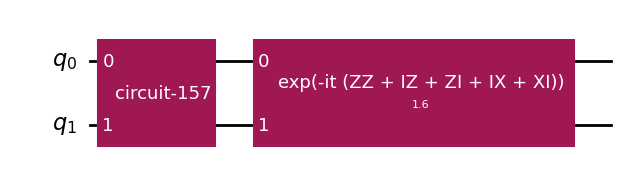

In [23]:
result.evolved_state.draw('mpl',style="iqp")

In [24]:
result.evolved_state.draw()

┌──────────────┐┌─────────────────────────────────────────┐
q_0: ┤0             ├┤0                                        ├
     │  circuit-157 ││  exp(-it (ZZ + IZ + ZI + IX + XI))(1.6) │
q_1: ┤1             ├┤1                                        ├
     └──────────────┘└─────────────────────────────────────────┘

/Users/pcchen/miniforge3/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


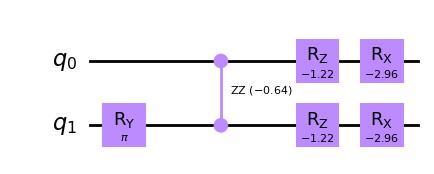

In [25]:
result.evolved_state.decompose(reps=2).decompose('disentangler_dg').decompose('multiplex1_reverse_dg').draw('mpl')

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-2.e-01+0.j,  1.e+00+0.j,  1.e+00+0.j, -1.e-05+0.j, -1.e-05+0.j])
SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j,  0.70710325+0.j,  0.70710325+0.j, -0.70711032+0.j,
 -0.70711032+0.j])
SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2+0.j, -0. +0.j, -0. +0.j, -1. +0.j, -1. +0.j])
SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.70710325+0.j, -0.70710325+0.j, -0.70711032+0.j,
 -0.70711032+0.j])
SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-2.e-01+0.j, -1.e+00+0.j, -1.e+00+0.j, -1.e-05+0.j, -1.e-05+0.j])


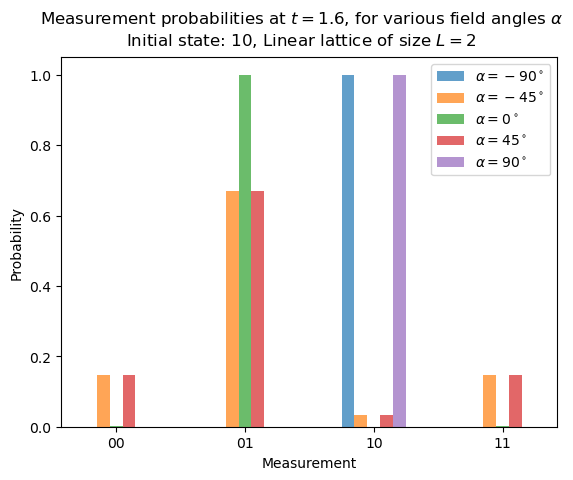

In [26]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = .1
# We prepare an initial state ↑↓ (01).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_state = Statevector.from_label("10")
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=2, J=.2, h=1., alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

In [28]:
print(alphas)

[-1.57078633 -0.78539316  0.          0.78539316  1.57078633]


In [29]:
from math import pi

L = 6
H = get_hamiltonian(L=L, J=.2, h=1.2, alpha=pi/8)

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.2       +0.j,
 -0.2       +0.j, -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j,
 -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j, -1.10865544+0.j,
 -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j,
 -1.10865544+0.j])


In [30]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

In [31]:
magnetization_op = SparsePauliOp.from_sparse_list([('Z', [i], 1.) for i in range(0, L)], num_qubits=L)
correlation_op = SparsePauliOp.from_sparse_list([('ZZ', [i, i+1], 1.) for i in range(0, L-1)], num_qubits=L) / (L - 1)

In [32]:
final_time = 30.
initial_state = Statevector.from_label('001100')
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])

In [33]:
result = trotter.evolve(problem)

In [17]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0.98, 'Observable evolution')

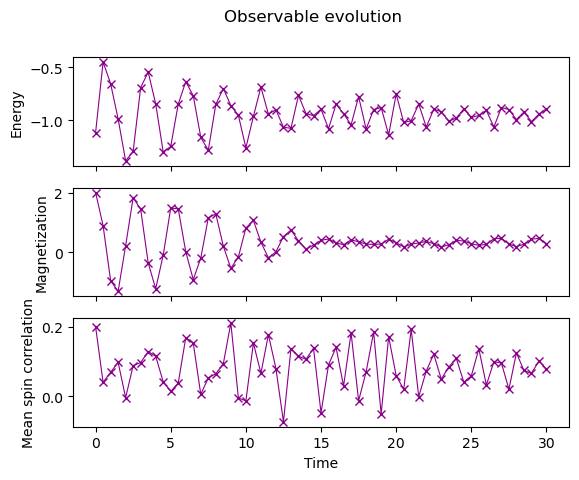

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state
axes[0].plot(times, observables[:, 0], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[1].plot(times, observables[:, 1], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[2].plot(times, observables[:, 2], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

In [21]:
import scipy as sc

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]

In [22]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

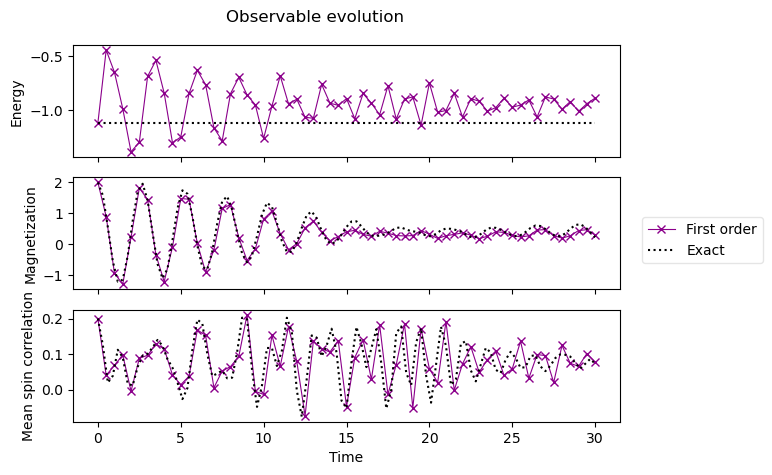

In [23]:
axes[0].plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
axes[1].plot(exact_times, exact_magnetization, c='k', ls=':', label='Exact')
axes[2].plot(exact_times, exact_correlation, c='k', ls=':', label='Exact')
# Select the labels of only the first axis
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig.tight_layout()
fig

In [24]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

In [25]:
# Let us print some stats
print(f"""
Trotter step with Lie-Trotter
-----------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
""")


Trotter step with Lie-Trotter
-----------------------------

                  Depth: 7
             Gate count: 17
    Nonlocal gate count: 5
         Gate breakdown: RZ: 6, RX: 6, RZZ: 5



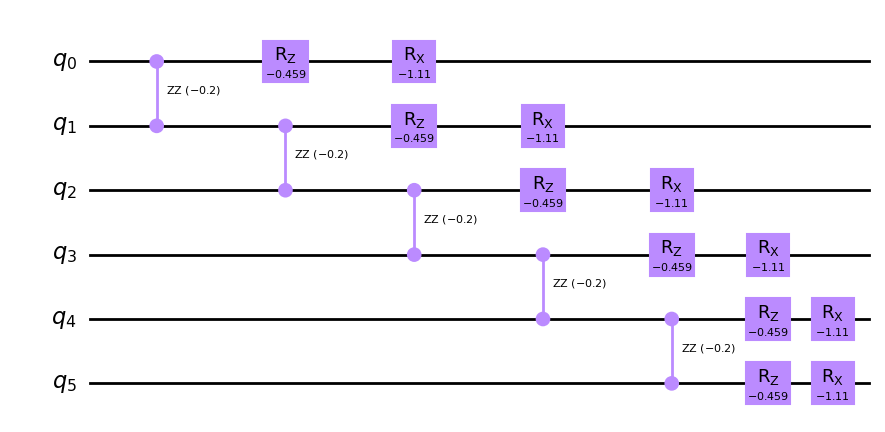

In [26]:
# And finally draw the circuit
circuit.draw('mpl')
